In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import argparse
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
def load_pep_and_codify(file, max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
        'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
    pep_codes=[]
    long_pep_counter = 0
    newLines = []
    for pep in lines:
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(current_pep)
            newLines.extend([pep])
        else:
            long_pep_counter += 1
    predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)
    return predict_data, long_pep_counter, newLines

In [3]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# 1. Make Data X_train, y_train, X_test, y_test

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = '../compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/'

In [5]:
# make DeepMSpeptide format
df_peptide_train = pd.read_csv('../data/df_detect_peptide_train_noptm_211018_includeDigest.csv')
df_peptide_test = pd.read_csv('../data/df_detect_peptide_test_noptm_211018_includeDigest.csv')

inp = open(file_path+'detect_peptide_train_noptm_largedata.txt', 'w')
inp_y = open(file_path+'detect_peptide_train_y_noptm_largedata.txt', 'w')
for x, y in df_peptide_train[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

inp = open(file_path+'detect_peptide_test_noptm_largedata.txt', 'w')
inp_y = open(file_path+'detect_peptide_test_y_noptm_largedata.txt', 'w')
for x, y in df_peptide_test[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

In [6]:
args = file_path + 'detect_peptide_train_noptm_largedata.txt'
print('Loading input peptides')
X_train, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_train_y_noptm_largedata.txt')
y_train = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test_noptm_largedata.txt'
print('Loading input peptides')
X_test, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_test_y_noptm_largedata.txt')
y_test = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

Loading input peptides
Succesfully loaded 641892 peptides and skipped 0
Loading input peptides
Succesfully loaded 129204 peptides and skipped 0
(513513, 30) (128379, 30) (129204, 30) (513513,) (128379,) (129204,)


# 2. train

In [7]:
model = tf.keras.Sequential([
    # vacabulary size 23 (22 AminoAcid + zero padding)
    # embedding vector size 50
    # input length (including padding) 30 ( 81 to 30)
    tf.keras.layers.Embedding(23, 50, input_length=30),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, strides=1),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 50)            1150      
_________________________________________________________________
dropout (Dropout)            (None, 30, 50)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 128)           19328     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 29, 64)            16448     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
__________________

In [8]:
history = model.fit(X_train, y_train, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val, y_val))

Train on 337179 samples, validate on 84295 samples
Epoch 1/200
337179/337179 [==============================] - 60s 179us/sample - loss: 0.6141 - acc: 0.7452 - val_loss: 0.5955 - val_acc: 0.8060
Epoch 2/200
337179/337179 [==============================] - 74s 220us/sample - loss: 0.5950 - acc: 0.7996 - val_loss: 0.5931 - val_acc: 0.8061
Epoch 3/200
337179/337179 [==============================] - 61s 181us/sample - loss: 0.5934 - acc: 0.8033 - val_loss: 0.5924 - val_acc: 0.8102
Epoch 4/200
337179/337179 [==============================] - 59s 174us/sample - loss: 0.5925 - acc: 0.8051 - val_loss: 0.5916 - val_acc: 0.8125
Epoch 5/200
337179/337179 [==============================] - 66s 196us/sample - loss: 0.5919 - acc: 0.8067 - val_loss: 0.5908 - val_acc: 0.8084
Epoch 6/200
337179/337179 [==============================] - 89s 265us/sample - loss: 0.5914 - acc: 0.8077 - val_loss: 0.5909 - val_acc: 0.8036
Epoch 7/200
337179/337179 [==============================] - 90s 266us/sample - loss:

337179/337179 [==============================] - 91s 270us/sample - loss: 0.5755 - acc: 0.8407 - val_loss: 0.5771 - val_acc: 0.8336
Epoch 58/200
337179/337179 [==============================] - 91s 270us/sample - loss: 0.5755 - acc: 0.8412 - val_loss: 0.5770 - val_acc: 0.8316
Epoch 59/200
337179/337179 [==============================] - 90s 268us/sample - loss: 0.5752 - acc: 0.8416 - val_loss: 0.5756 - val_acc: 0.8393
Epoch 60/200
337179/337179 [==============================] - 91s 270us/sample - loss: 0.5752 - acc: 0.8419 - val_loss: 0.5758 - val_acc: 0.8378
Epoch 61/200
337179/337179 [==============================] - 92s 273us/sample - loss: 0.5751 - acc: 0.8420 - val_loss: 0.5757 - val_acc: 0.8376
Epoch 62/200
337179/337179 [==============================] - 90s 266us/sample - loss: 0.5752 - acc: 0.8422 - val_loss: 0.5755 - val_acc: 0.8400
Epoch 63/200
337179/337179 [==============================] - 91s 269us/sample - loss: 0.5749 - acc: 0.8423 - val_loss: 0.5765 - val_acc: 0.841

337179/337179 [==============================] - 32s 96us/sample - loss: 0.5730 - acc: 0.8468 - val_loss: 0.5745 - val_acc: 0.8416
Epoch 114/200
337179/337179 [==============================] - 32s 96us/sample - loss: 0.5732 - acc: 0.8467 - val_loss: 0.5753 - val_acc: 0.8383
Epoch 115/200
337179/337179 [==============================] - 33s 97us/sample - loss: 0.5728 - acc: 0.8477 - val_loss: 0.5744 - val_acc: 0.8428
Epoch 116/200
337179/337179 [==============================] - 33s 97us/sample - loss: 0.5730 - acc: 0.8471 - val_loss: 0.5747 - val_acc: 0.8392
Epoch 117/200
337179/337179 [==============================] - 32s 96us/sample - loss: 0.5731 - acc: 0.8465 - val_loss: 0.5751 - val_acc: 0.8462
Epoch 118/200
337179/337179 [==============================] - 32s 96us/sample - loss: 0.5728 - acc: 0.8475 - val_loss: 0.5752 - val_acc: 0.8399
Epoch 119/200
337179/337179 [==============================] - 33s 97us/sample - loss: 0.5731 - acc: 0.8465 - val_loss: 0.5744 - val_acc: 0.8460

337179/337179 [==============================] - 33s 97us/sample - loss: 0.5718 - acc: 0.8499 - val_loss: 0.5746 - val_acc: 0.8405
Epoch 170/200
337179/337179 [==============================] - 33s 97us/sample - loss: 0.5718 - acc: 0.8497 - val_loss: 0.5747 - val_acc: 0.8405
Epoch 171/200
337179/337179 [==============================] - 33s 97us/sample - loss: 0.5718 - acc: 0.8497 - val_loss: 0.5745 - val_acc: 0.8443
Epoch 172/200
337179/337179 [==============================] - 33s 97us/sample - loss: 0.5719 - acc: 0.8493 - val_loss: 0.5744 - val_acc: 0.8396
Epoch 173/200
337179/337179 [==============================] - 33s 97us/sample - loss: 0.5718 - acc: 0.8499 - val_loss: 0.5751 - val_acc: 0.8384
Epoch 174/200
337179/337179 [==============================] - 33s 97us/sample - loss: 0.5716 - acc: 0.8501 - val_loss: 0.5743 - val_acc: 0.8440
Epoch 175/200
337179/337179 [==============================] - 33s 98us/sample - loss: 0.5717 - acc: 0.8501 - val_loss: 0.5757 - val_acc: 0.8369

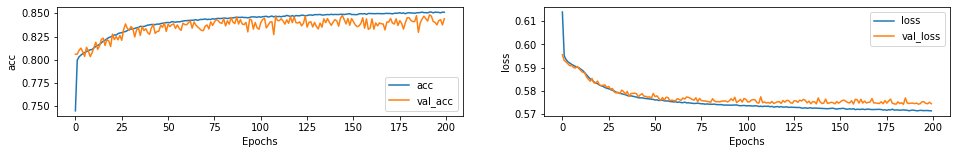

In [9]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'acc')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# 2-2. Github code

In [12]:
args = file_path + 'detect_peptide_train_noptm_largedata.txt'
print('Loading input peptides')
X_train81, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'detect_peptide_train_y_noptm_largedata.txt')
y_train81 = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test_noptm_largedata.txt'
print('Loading input peptides')
X_test81, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'detect_peptide_test_y_noptm_largedata.txt')
y_test81 = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train81, X_val81, y_train81, y_val81 = train_test_split(X_train81, y_train81, test_size=0.2)
print(X_train81.shape, X_val81.shape, X_test81.shape, y_train81.shape, y_val81.shape, y_test81.shape)


print('Loading model...')
model_2_1D = keras.models.load_model(file_path + 'model_2_1D.h5')
print(model_2_1D.summary())

Loading input peptides
Succesfully loaded 421474 peptides and skipped 0
Loading input peptides
Succesfully loaded 88998 peptides and skipped 0
(337179, 81) (84295, 81) (88998, 81) (337179,) (84295,) (88998,)
Loading model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 50)            1150      
_________________________________________________________________
dropout_2 (Dropout)          (None, 81, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 81, 128)           19328     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 80, 64)            16448     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
___________________________

In [8]:
history_github = model_2_1D.fit(X_train81, y_train81, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val81, y_val81))

plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history_github, 'acc')
plt.subplot(1,2,2)
plot_graphs(history_github, 'loss')

Loading input peptides
Succesfully loaded 421474 peptides and skipped 0
Loading input peptides
Succesfully loaded 88998 peptides and skipped 0
(337179, 81) (84295, 81) (88998, 81) (337179,) (84295,) (88998,)
Loading model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 337179 samples, validate on 84295 samples
Epoch 1/200
337179/337179 [==============================] - 964s 3ms/sample - loss: 0.4320 - acc: 0.7947 - binary_crossentropy: 0.4320 - val_loss: 0.3749 - val_acc: 0.8285 - val_binary_crossentropy: 0.3749
Epoch 2/200
337179/337179 [==============================] - 871s 3ms/sample - loss: 0.3768 - acc: 0.8300 - binary_crossentropy: 0.3768 - val_loss: 0.3589 - val_acc: 0.8368 - val_binary_crossentropy: 0.3589
Epoch 3/200
337179/337179 [==============================] - 352s 1ms/samp

Epoch 35/200
337179/337179 [==============================] - 46s 137us/sample - loss: 0.3273 - acc: 0.8564 - binary_crossentropy: 0.3273 - val_loss: 0.3363 - val_acc: 0.8501 - val_binary_crossentropy: 0.3363
Epoch 36/200
337179/337179 [==============================] - 54s 161us/sample - loss: 0.3270 - acc: 0.8554 - binary_crossentropy: 0.3270 - val_loss: 0.3363 - val_acc: 0.8498 - val_binary_crossentropy: 0.3363
Epoch 37/200
337179/337179 [==============================] - 54s 161us/sample - loss: 0.3266 - acc: 0.8566 - binary_crossentropy: 0.3266 - val_loss: 0.3353 - val_acc: 0.8506 - val_binary_crossentropy: 0.3353
Epoch 38/200
337179/337179 [==============================] - 54s 160us/sample - loss: 0.3260 - acc: 0.8564 - binary_crossentropy: 0.3260 - val_loss: 0.3393 - val_acc: 0.8466 - val_binary_crossentropy: 0.3393
Epoch 39/200
337179/337179 [==============================] - 54s 161us/sample - loss: 0.3258 - acc: 0.8569 - binary_crossentropy: 0.3258 - val_loss: 0.3389 - val_a

KeyboardInterrupt: 

# 3. test

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

88998/88998 [==============================] - 5s 57us/sample - loss: 0.5709 - acc: 0.8633
Test Loss: 0.5709129505651571
Test Accuracy: 0.8633227944374084
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     44509
           1       0.86      0.86      0.86     44489

    accuracy                           0.86     88998
   macro avg       0.86      0.86      0.86     88998
weighted avg       0.86      0.86      0.86     88998

rf auc : 0.9220931892847226


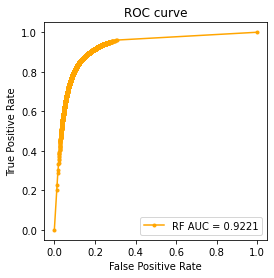

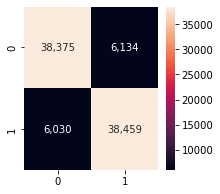

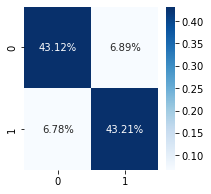

In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

88998/88998 [==============================] - 7s 77us/sample - loss: 0.3391 - acc: 0.8542 - binary_crossentropy: 0.3391
Test Loss: 0.569490050697046
Test Accuracy: [0.33912464481447113, 0.8541877, 0.33912423]
              precision    recall  f1-score   support

           0       0.91      0.79      0.84     44509
           1       0.81      0.92      0.86     44489

    accuracy                           0.85     88998
   macro avg       0.86      0.85      0.85     88998
weighted avg       0.86      0.85      0.85     88998

rf auc : 0.9339800137281874


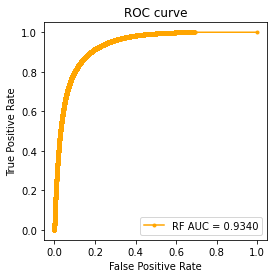

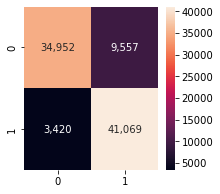

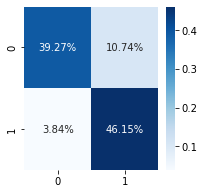

In [14]:
test_acc = model_2_1D.evaluate(X_test81, y_test81)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_2_1D.predict(X_test81)]
print(classification_report(y_test81, y_pred))
# AUC
probs = model_2_1D.predict(X_test81)
rf_auc = roc_auc_score(y_test81, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test81, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test81, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

# check zero MSGF peptides property

In [15]:
import pickle

with open('pep_zeroMSGF_noptm.pickle', 'rb') as f:
    pep_zeroMSGF_noptm = pickle.load(f)

In [16]:
max_len=81

aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
    'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
pep_codes=[]
newLines = []
for pep in pep_zeroMSGF_noptm:
    if not len(pep) > max_len:
        current_pep=[]
        for aa in pep:
            current_pep.append(aa_dict[aa])
        pep_codes.append(current_pep)
        newLines.extend([pep])
predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)

In [17]:
predict_label = np.array([0]*len(predict_data))

In [18]:
test_acc = model_2_1D.evaluate(predict_data, predict_label)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_2_1D.predict(predict_data)]
print(classification_report(predict_label, y_pred))

93542/93542 [==============================] - 7s 77us/sample - loss: 1.0802 - acc: 0.6148 - binary_crossentropy: 1.0802
Test Loss: 0.569490050697046
Test Accuracy: [1.0802476228004148, 0.6147613, 1.0802478]
              precision    recall  f1-score   support

           0       1.00      0.61      0.76     93542
           1       0.00      0.00      0.00         0

    accuracy                           0.61     93542
   macro avg       0.50      0.31      0.38     93542
weighted avg       1.00      0.61      0.76     93542



/home/bis/miniconda3/envs/TF1.14/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bis/miniconda3/envs/TF1.14/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bis/miniconda3/envs/TF1.14/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
y_prob = model_2_1D.predict(predict_data)

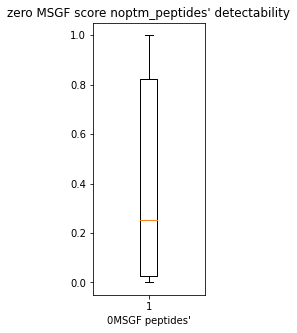

In [20]:
plt.figure(figsize=(2,5))
plt.boxplot(y_prob.reshape(-1))
plt.title('zero MSGF score noptm_peptides\' detectability')
plt.xlabel('0MSGF peptides\'')
plt.show()

# check zero MSGF peptides property

In [60]:
peps = pd.read_csv('211018MS2real_problem_possibility.csv')

In [61]:
predict_label = peps.ID.values
Xs = peps.PEP.values

max_len=81
aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
    'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
pep_codes=[]
newLines = []
for pep in Xs:
    if not len(pep) > max_len:
        current_pep=[]
        for aa in pep:
            current_pep.append(aa_dict[aa])
        pep_codes.append(current_pep)
        newLines.extend([pep])
predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)

test_acc = model_2_1D.evaluate(predict_data, predict_label)
y_prob = model_2_1D.predict(predict_data)

4482/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Loss: 0.7256193236328596
Test Accuracy: [1.3817841180380305e-05, 1.0, 1.3817841e-05]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4482

    accuracy                           1.00      4482
   macro avg       1.00      1.00      1.00      4482
weighted avg       1.00      1.00      1.00      4482



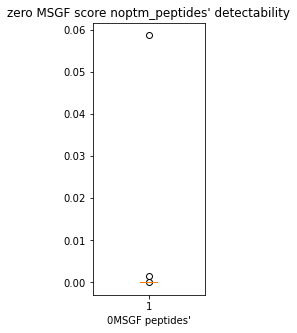

In [62]:
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_2_1D.predict(predict_data)]
print(classification_report(predict_label, y_pred))

plt.figure(figsize=(2,5))
plt.boxplot(y_prob.reshape(-1))
plt.title('zero MSGF score noptm_peptides\' detectability')
plt.xlabel('0MSGF peptides\'')
plt.show()

In [63]:
peps = pd.read_csv('211018MS2problem_possibility.csv')

predict_label = peps.ID.values
Xs = peps.PEP.values

max_len=81
aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
    'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
pep_codes=[]
newLines = []
for pep in Xs:
    if not len(pep) > max_len:
        current_pep=[]
        for aa in pep:
            current_pep.append(aa_dict[aa])
        pep_codes.append(current_pep)
        newLines.extend([pep])
predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)

test_acc = model_2_1D.evaluate(predict_data, predict_label)
y_prob = model_2_1D.predict(predict_data)

7479/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Loss: 0.7256193236328596
Test Accuracy: [0.39134853859925783, 0.83446985, 0.39134845]
              precision    recall  f1-score   support

           0       0.83      0.72      0.77      2911
           1       0.84      0.91      0.87      4568

    accuracy                           0.83      7479
   macro avg       0.83      0.81      0.82      7479
weighted avg       0.83      0.83      0.83      7479



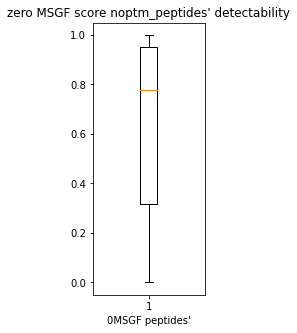

In [64]:
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_2_1D.predict(predict_data)]
print(classification_report(predict_label, y_pred))

plt.figure(figsize=(2,5))
plt.boxplot(y_prob.reshape(-1))
plt.title('zero MSGF score noptm_peptides\' detectability')
plt.xlabel('0MSGF peptides\'')
plt.show()

# initial model test
 - AUC 91? 93?

In [ ]:
df_gpmdb = pd.read_csv('../compareModel/2019Bioinformatics_DeepMSPeptide/Datasets/GPMDB_training_peptides.txt', sep='\t')
df_gpmdb = df_gpmdb[['Peptide_seq', 'Class']]
y_train_gpmdb = df_gpmdb['Class'].apply(lambda x: {'MObs':1, 'LObs':0}[x]).values
Xs = df_gpmdb.Peptide_seq.values
max_len=30
aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
    'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
pep_codes=[]
newLines = []
for pep in Xs:
    if not len(pep) > max_len:
        current_pep=[]
        for aa in pep:
            current_pep.append(aa_dict[aa])
        pep_codes.append(current_pep)
        newLines.extend([pep])
X_train_gpmdb = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)

In [ ]:
model.fit(X_train_gpmdb, y_train_gpmdb, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val, y_val))

88998/88998 [==============================] - 7s 77us/sample - loss: 0.3391 - acc: 0.8542 - binary_crossentropy: 0.3391
Test Loss: 0.569490050697046
Test Accuracy: [0.33912464481447113, 0.8541877, 0.33912423]
              precision    recall  f1-score   support

           0       0.91      0.79      0.84     44509
           1       0.81      0.92      0.86     44489

    accuracy                           0.85     88998
   macro avg       0.86      0.85      0.85     88998
weighted avg       0.86      0.85      0.85     88998

rf auc : 0.9339800137281874


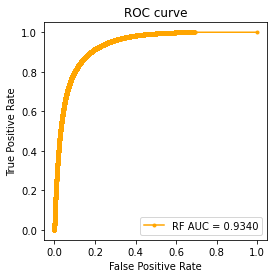

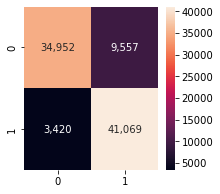

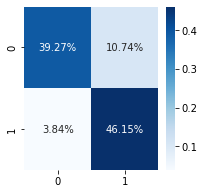

In [14]:
test_acc = model.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()